# Ejecución de estrategia de manera simple con la última actualización de manera local sin testnet.

<function matplotlib.pyplot.show(close=None, block=None)>

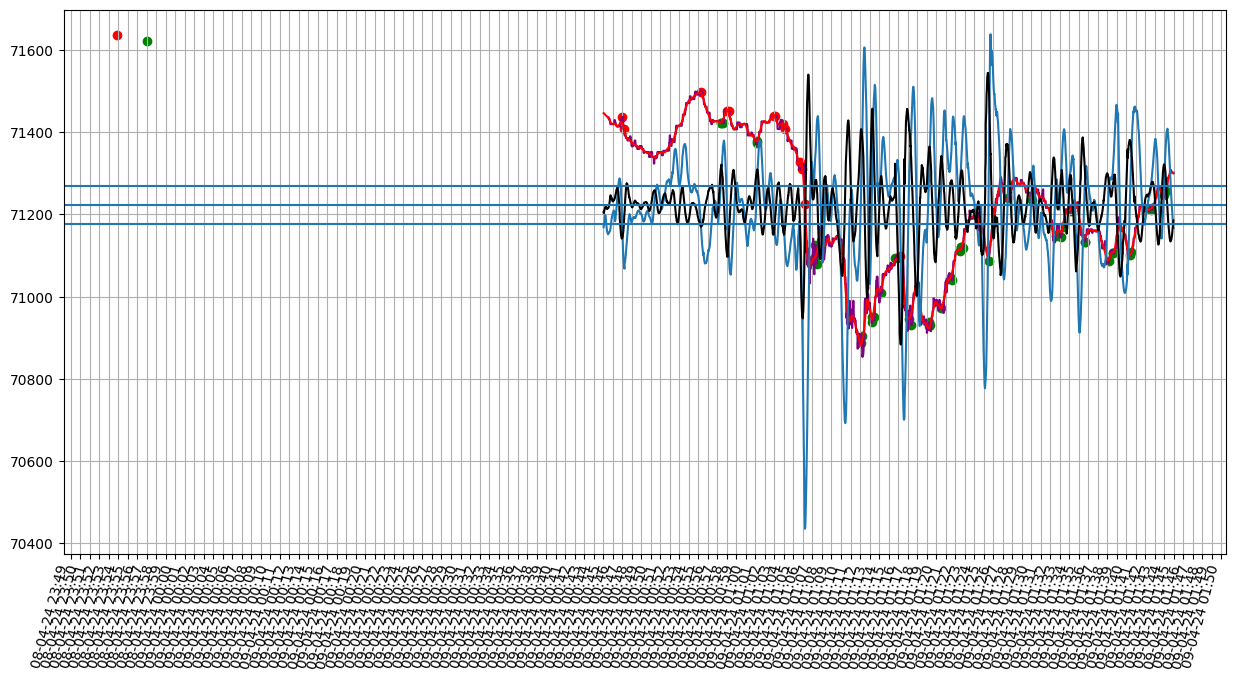

In [49]:
################################################################################################################################################################################
# Importamos las librerías necesarias y generamos conexión con Binance para descargar la lista de pares que binance maneja.
################################################################################################################################################################################
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from binance import Client

client = Client()

##################################################
# Lista de parámetros.
##################################################
# Parámetros de interpolación.
###################################
smooth_interval = 60
smooth_exp = 3
###################################
# Parámetros de estrategia.
###################################
rango = 30
std_mult = 750
z_aprox = 0.009


##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################
recent_data = pd.read_csv('../csvs/streaming/BTCUSDT.csv')
recent_data.columns = ['Tiempo','Par','Precio']
recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
recent_data = recent_data.set_index('Tiempo')
recent_data['Precio'] = recent_data.Precio.astype('Float32')
recent_data = recent_data.reset_index()

##################################################
# Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
##################################################
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Precio,smooth_interval,smooth_exp)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,smooth_exp)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,smooth_exp)
recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)

######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-60*60:-60*60 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango

# initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[60*30:60*30 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() + rango
# final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[60*80:60*80 + 1].item()),'%Y-%m-%d %H:%M:%S.%f')].index.item() - rango

lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index]['TD_Interpolacion'] >= -z_aprox) & (recent_data[initial_date_index:final_date_index]['TD_Interpolacion'] <= z_aprox)]
indices_min_max = lista_min_max.index.tolist()

max_points_idx = []
min_points_idx = []
pmin = 0
pmax = 0

for PMSD in indices_min_max:
    if recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0:
        if (abs(recent_data.SD_Interpolacion[PMSD]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*100) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmax = recent_data.SD_Interpolacion[PMSD]
            pmax_idx = PMSD
        for i in range(rango+1):
            # if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
            #     break
            if ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD-i]*1000)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*100) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD+i]*1000)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*100) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD+i
        try:
            max_points_idx.append(pmax_idx)
        except:
            pass
    elif recent_data.SD_Interpolacion[PMSD:PMSD+1].item() < 0:
        if (abs(recent_data.SD_Interpolacion[PMSD]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*10) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmin = recent_data.SD_Interpolacion[PMSD]
            pmin_idx = PMSD
        for i in range(rango+1):
            # if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
            #     break
            if ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD-i]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*100) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD+i]*1000) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*100) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD+i
        try:
            min_points_idx.append(pmin_idx)
        except:
            pass
max_points_idx = list(set(max_points_idx))
min_points_idx = list(set(min_points_idx))
max_points_idx.sort()
min_points_idx.sort()
close_points_max = []
close_points_min = []
for lista in [max_points_idx,min_points_idx]:
    for i in range(len(lista)-1):
        if lista[i+1]-lista[i] == 1:
            if lista == max_points_idx:
                close_points_max.append(i+1)
            else:
                close_points_min.append(i+1)
    if lista == max_points_idx:
        for idx in sorted(close_points_max,reverse=True):
            del lista[idx]
    else:
        for idx in sorted(close_points_min,reverse=True):
            del lista[idx]


##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################
mp = recent_data.Precio[initial_date_index:final_date_index].mean()
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Precio[initial_date_index:final_date_index].multiply(1),color='purple')
plt.plot(recent_data.Tiempo[initial_date_index-rango:final_date_index],recent_data.Interpolacion[initial_date_index-rango:final_date_index].multiply(1),color='red')
plt.plot(recent_data.Tiempo[initial_date_index-rango:final_date_index],recent_data.PD_Interpolacion[initial_date_index-rango:final_date_index].multiply(100)+mp)
plt.plot(recent_data.Tiempo[initial_date_index-rango:final_date_index],recent_data.SD_Interpolacion[initial_date_index-rango:final_date_index].multiply(1000)+mp,color='k')
plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Precio.iloc[max_points_idx],color='g')
plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Precio.iloc[min_points_idx],color='r')
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.dropna().SD_Interpolacion)*std_mult + mp)
plt.axhline(mp - np.std(recent_data.dropna().SD_Interpolacion)*std_mult)
plt.show

In [47]:
pmax_df = recent_data.iloc[max_points_idx].loc[:,['Tiempo','Precio']]
pmax_df['Accion'] = 'C'
pmin_df = recent_data.iloc[min_points_idx].loc[:,['Tiempo','Precio']]
pmin_df['Accion'] = 'V'
vc_df = pd.concat([pmax_df,pmin_df],axis=1)
vc_df = vc_df.reset_index()
vc_df = vc_df.set_index('index')
vc_df = pd.concat([pmax_df,pmin_df],axis=0)
vc_df = vc_df.sort_index()
del_idx = []
vc_df = vc_df.reset_index()
for i in vc_df.index:
    try:
        if vc_df.Accion[i+1] == vc_df.Accion[i]:
            del_idx.append(i+1)
    except:
        pass
vc_df.drop(del_idx,inplace=True)
vc_df = vc_df.reset_index(drop=True)
vc_df['Diferencia_Precio_USDT'] = pd.Series(dtype='float')
for i in range(len(vc_df)-1):
    vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Precio[i+1] - vc_df.Precio[i]) * 0.001
profits = 0
for i in range(len(vc_df)-1):
    if vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
profits

C:\Users\tinma\AppData\Local\Temp\ipykernel_31344\2326317553.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Precio[i+1] - vc_df.Precio[i]) * 0.001


1.0026015625